In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

torch.manual_seed(11)

def crop(X):
    res = np.zeros((len(X), len(X[0]), 300, 300))
    for p in range(len(X)):
        for s in range(len(X[p])):
            for i in range(106, 406):
                res[p][s][i - 106] = X[p][s][i][106:406]
    return res


# MRIs
X = np.load('small_data.npy')
X = crop(X)


# labels
y = pd.read_csv('all_target.csv')
y.columns = ['y']

# devide into 2 classes: no cut / cut - (0 / 1)
y = np.where(y.y <= 3, 0, 1)

c, h = np.unique(y, return_counts=True)
plt.bar(c, h);

(array([0, 1]), array([680, 680]))


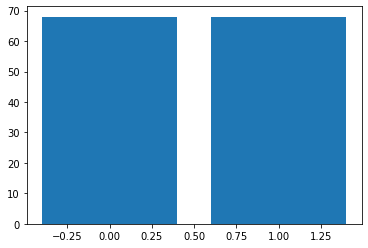

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=45)

X_temp = X.reshape((810, -1))
y_temp = np.array([[i]*10 for i in y]).reshape((810, -1))

X_smote, y_smote = sm.fit_resample(X_temp, y_temp)

print(np.unique(y_smote, return_counts=True))

X = X_smote.reshape((136, 10, 300, 300))
y = []
for i in range(0, 1360, 10):
    y.append(y_smote[i])
    
    
c, h = np.unique(y, return_counts=True)
plt.bar(c, h, );

In [3]:
X = torch.from_numpy(X).to(torch.float32).reshape((136, 10, 300, 300))
y = torch.tensor(y).reshape((-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
class pinn(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU()
        )
        
        self.class_layers = nn.Sequential(
            nn.Linear(16*292**2, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.Linear(100, 10),
            nn.Linear(10, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.class_layers(x.reshape((self.batch_size, -1, 16*292**2)))
        
        return x.squeeze(1)

In [10]:
# Batches
batch_size = 1

# X_train
X_train_loader = torch.utils.data.DataLoader(
    X_train,
    batch_size=batch_size
)

# y_train
y_train_loader = torch.utils.data.DataLoader(
    y_train,
    batch_size=batch_size
)

In [12]:
mod = pat_nn(batch_size)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(mod.parameters(), lr=0.01)

losses = []
accs = []
for epoch in range(1, 5):
    print(f'Epoch: {epoch}')
    y_train_iter = iter(y_train_loader)
    loss_sum = 0
    cnt = 0
    for sample in X_train_loader:
        cnt += 1
        preds = mod(sample)
        label = next(y_train_iter).flatten()
        loss = criterion(preds, label)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        loss_sum += loss.item()
        
        if cnt % 10 == 0:
            av_loss = loss_sum / cnt
            losses.append(av_loss)
            print(f'Avg loss: {loss_sum / cnt}')
            
        if cnt == len(y_train) // 2:
            with torch.no_grad():
                tp = 0
                fp = 0
                fn = 0
                tn = 0
                for i, sample in enumerate(X_test):
                    sample = sample.unsqueeze(0)

                    preds = torch.argmax(mod(sample)).item()
                    label = y_test[i].item()

                    if preds == label:
                        if label == 1:
                            tp += 1
                        else:
                            tn += 1

                    else:
                        if label == 1:
                            fn += 1
                        else:
                            fp += 1

                acc = (tp + tn) / len(y_test)
                accs.append(acc)
                print(f'Test accuracy: {acc}')

    losses.append(loss_sum / len(X_train))
        
    # test

    with torch.no_grad():
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i, sample in enumerate(X_test):
            sample = sample.unsqueeze(0)

            preds = torch.argmax(mod(sample)).item()
            label = y_test[i].item()

            if preds == label:
                if label == 1:
                    tp += 1
                else:
                    tn += 1

            else:
                if label == 1:
                    fn += 1
                else:
                    fp += 1

        acc = (tp + tn) / len(y_test)
        accs.append(acc)
        print(f'Test accuracy: {acc}')

Epoch: 1
Avg loss: 78167529.21739317
Avg loss: 39083798.34045884
Avg loss: 26055866.451215204
Avg loss: 19541900.104265194
Test accuracy: 0.6
Avg loss: 15633520.239435913
Avg loss: 13027933.650273856
Avg loss: 11166800.363693269
Avg loss: 9770950.39551365
Avg loss: 8685289.317644428
Test accuracy: 0.4
Epoch: 2
Avg loss: 0.8614369213581086
Avg loss: 0.8123627096414566
Avg loss: 0.7719606737295787
Avg loss: 0.7482781022787094
Test accuracy: 0.6
Avg loss: 0.7461556875705719
Avg loss: 0.7397640446821848
Avg loss: 0.7272464454174041
Avg loss: 0.71389724239707
Avg loss: 0.7115962581502067
Test accuracy: 0.4
Epoch: 3
Avg loss: 0.8605825781822205
Avg loss: 0.8119062691926956
Avg loss: 0.7716786881287893
Avg loss: 0.7480709552764893
Test accuracy: 0.6
Avg loss: 0.7459871804714203
Avg loss: 0.739603266119957
Avg loss: 0.7270693804536547
Avg loss: 0.7137304116040468
Avg loss: 0.7114553146892124
Test accuracy: 0.4
Epoch: 4
Avg loss: 0.8605812847614288
Avg loss: 0.8119639039039612
Avg loss: 0.77165

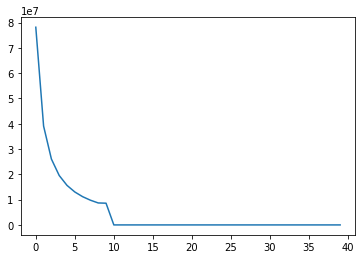

In [15]:
losses

plt.plot(range(len(losses)), losses)

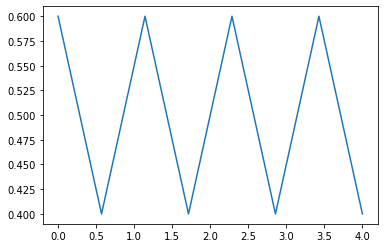

In [24]:
plt.plot(np.linspace(0, 4, 8), accs)